In [1]:
import numpy as np 
import pandas as pd 
from scipy.stats import zscore

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve, auc, roc_curve, classification_report
import shap

import contextlib
import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')


In [2]:
data = pd.read_csv('/kaggle/input/casestudy/DataScientist_CaseStudy.csv')

### Data preprocessing

In [3]:
data.columns = data.columns.str.strip()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10509 entries, 0 to 10508
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   RiskPerformance       10507 non-null  object 
 1   ExternalRiskEstimate  10493 non-null  float64
 2   MonthsOldestTrade     10487 non-null  float64
 3   MonthsRecentTrade     10497 non-null  float64
 4   AvgMonthsInFile       10487 non-null  float64
 5   SatisfactoryTrades    10496 non-null  float64
 6   Trades60Late          10497 non-null  float64
 7   Trades90Late          10494 non-null  float64
 8   PercentNeverDelinq    10491 non-null  float64
 9   MonthsRecentDelinq    10495 non-null  float64
 10  MaxDelinq12M          10492 non-null  float64
 11  MaxDelinqEver         10485 non-null  float64
 12  TotalTrades           10495 non-null  float64
 13  RecentTradesOpen      10492 non-null  float64
 14  InstallmentPercent    10490 non-null  float64
 15  MonthsRecentInq    

In [5]:
data.describe()

,ExternalRiskEstimate,MonthsOldestTrade,MonthsRecentTrade,AvgMonthsInFile,SatisfactoryTrades,Trades60Late,Trades90Late,PercentNeverDelinq,MonthsRecentDelinq,MaxDelinq12M,...,InstallmentPercent,MonthsRecentInq,Inquiries6M,Inquiries6MEx7D,RevolvingUtil,InstallmentUtil,RevolvingWithBal,InstallmentWithBal,HighUtilTrades,PercentWithBal
count,10493.000000,10487.000000,10497.000000,10487.000000,10496.000000,10497.000000,10494.000000,10491.000000,10495.000000,10492.000000,...,10490.000000,10494.000000,10494.000000,10495.000000,10495.000000,10491.000000,10494.000000,10498.000000,10489.000000,10492.000000
mean,67.438769,184.152379,8.545013,73.866692,19.422828,0.041440,-0.143225,86.670098,6.749404,4.929661,...,32.195520,-0.335430,0.869354,0.818009,31.631634,39.211801,3.182866,0.970280,0.015635,62.078536
std,21.114483,109.696283,13.299081,38.784694,13.009307,2.515216,2.366894,26.012901,20.512429,3.757395,...,20.148845,6.078627,3.179557,3.168335,30.047082,42.320261,4.411503,4.072328,3.356651,27.715680
min,-9.000000,-128.000000,-15.000000,-9.000000,-13.000000,-9.000000,-9.000000,-9.000000,-51.000000,-9.000000,...,-18.000000,-40.000000,-9.000000,-9.000000,-24.000000,-38.000000,-9.000000,-33.000000,-9.000000,-9.000000
25%,63.000000,118.000000,3.000000,52.000000,12.000000,0.000000,0.000000,87.000000,-7.000000,4.000000,...,20.000000,-7.000000,0.000000,0.000000,5.000000,-8.000000,2.000000,1.000000,0.000000,47.000000
50%,71.000000,178.000000,5.000000,74.000000,19.000000,0.000000,0.000000,96.000000,-7.000000,6.000000,...,31.000000,0.000000,1.000000,1.000000,25.000000,47.000000,3.000000,2.000000,0.000000,67.000000
75%,80.000000,249.000000,11.000000,95.000000,27.000000,1.000000,0.000000,100.000000,14.000000,7.000000,...,44.000000,1.000000,2.000000,2.000000,54.000000,79.000000,5.000000,3.000000,1.000000,82.000000
max,106.000000,803.000000,383.000000,383.000000,79.000000,19.000000,19.000000,147.000000,83.000000,12.000000,...,100.000000,24.000000,66.000000,66.000000,232.000000,477.000000,32.000000,23.000000,18.000000,152.000000


##### Dealing with missing values:

Remove all rows with missing values because it only consists a small portion of the whole dataset

In [6]:
# Remove all rows with missing values
data = data.dropna()

# Check how many rows are left after removing rows with missing values
rows_left = len(data)

print(f"Number of rows left after removing missing values: {rows_left}")

Number of rows left after removing missing values: 10459


##### Deal with outliers

Remove outliers according to zscore value.

In [7]:
predictors = data.drop(['RiskPerformance'], axis = 1)

In [8]:
# Calculate the z-scores for numerical columns
z_scores = predictors.apply(zscore)

# Define outliers as those with a z-score greater than 3 or less than -3
outliers_zscore = (z_scores.abs() > 3).sum()

# Display the number of outliers for each predictor using the z-score method
outliers_zscore

ExternalRiskEstimate    598
MonthsOldestTrade        35
MonthsRecentTrade       156
AvgMonthsInFile          78
SatisfactoryTrades       57
Trades60Late            629
Trades90Late            628
PercentNeverDelinq      594
MonthsRecentDelinq      215
MaxDelinq12M            588
MaxDelinqEver           588
TotalTrades              73
RecentTradesOpen        607
InstallmentPercent       78
MonthsRecentInq         217
Inquiries6M             647
Inquiries6MEx7D         643
RevolvingUtil             7
InstallmentUtil           3
RevolvingWithBal         45
InstallmentWithBal       11
HighUtilTrades           20
PercentWithBal            0
dtype: int64

In [9]:
threshold = 3
data = data[(z_scores < threshold).all(axis=1) & (z_scores > -threshold).all(axis=1)]

In [10]:
data.shape

(8886, 24)

##### Encode target variable and check whether data is imbalanced

In [11]:
# Encode the target variable for correlation analysis (High Risk: 1, Low Risk: 0)
data['RiskPerformanceEncoded'] = data['RiskPerformance'].apply(lambda x: 1 if x == 'High Risk' else 0)   # Convert target to binary (1 for High Risk, 0 for Low Risk)

In [12]:
# Check the balance of the target variable 'RiskPerformanceEncoded'
high_risk_count = data['RiskPerformanceEncoded'].value_counts()

# Calculate the percentage of each class
high_risk_percentage = high_risk_count / len(data) * 100

# Print the counts and percentages of each class
print("Counts of each class (High Risk = 1, Low Risk = 0):")
print(high_risk_count)

print("\nPercentage of each class:")
print(high_risk_percentage)

Counts of each class (High Risk = 1, Low Risk = 0):
RiskPerformanceEncoded
1    4640
0    4246
Name: count, dtype: int64

Percentage of each class:
RiskPerformanceEncoded
1    52.216971
0    47.783029
Name: count, dtype: float64


### Data Visualisation

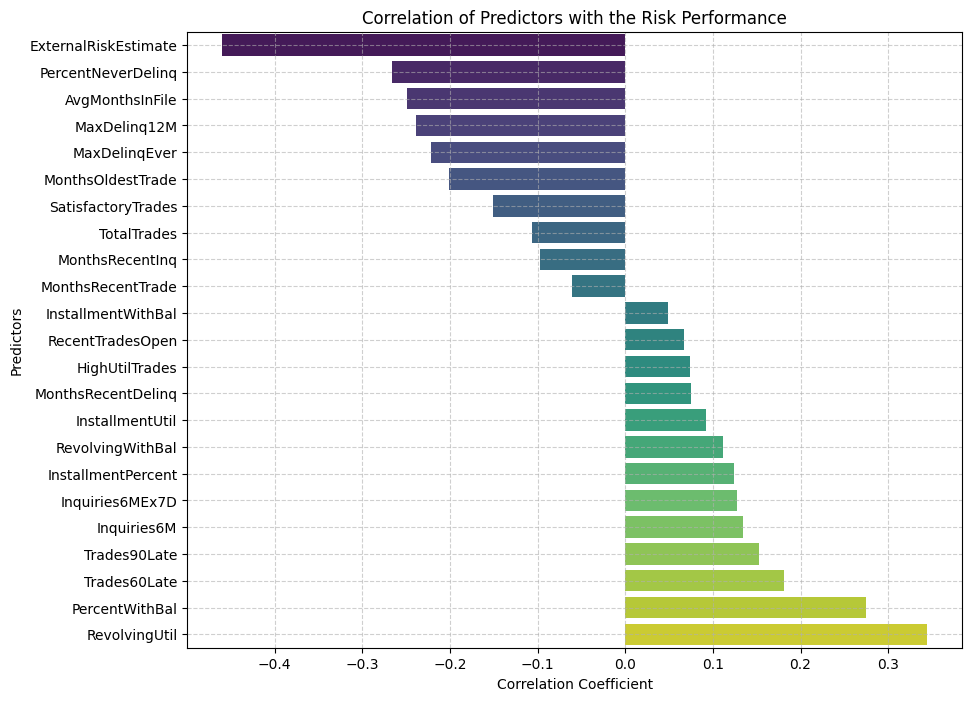

In [13]:
# Calculate correlations between all predictors and the encoded target variable
correlations = data.drop(columns=['RiskPerformance']).corrwith(data['RiskPerformanceEncoded']).sort_values()

# Drop the target variable: 
corr_plot = correlations.drop('RiskPerformanceEncoded')

# Plot correlations with the target variable
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_plot.values, y=corr_plot.index, palette="viridis")
plt.title('Correlation of Predictors with the Risk Performance')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Predictors')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

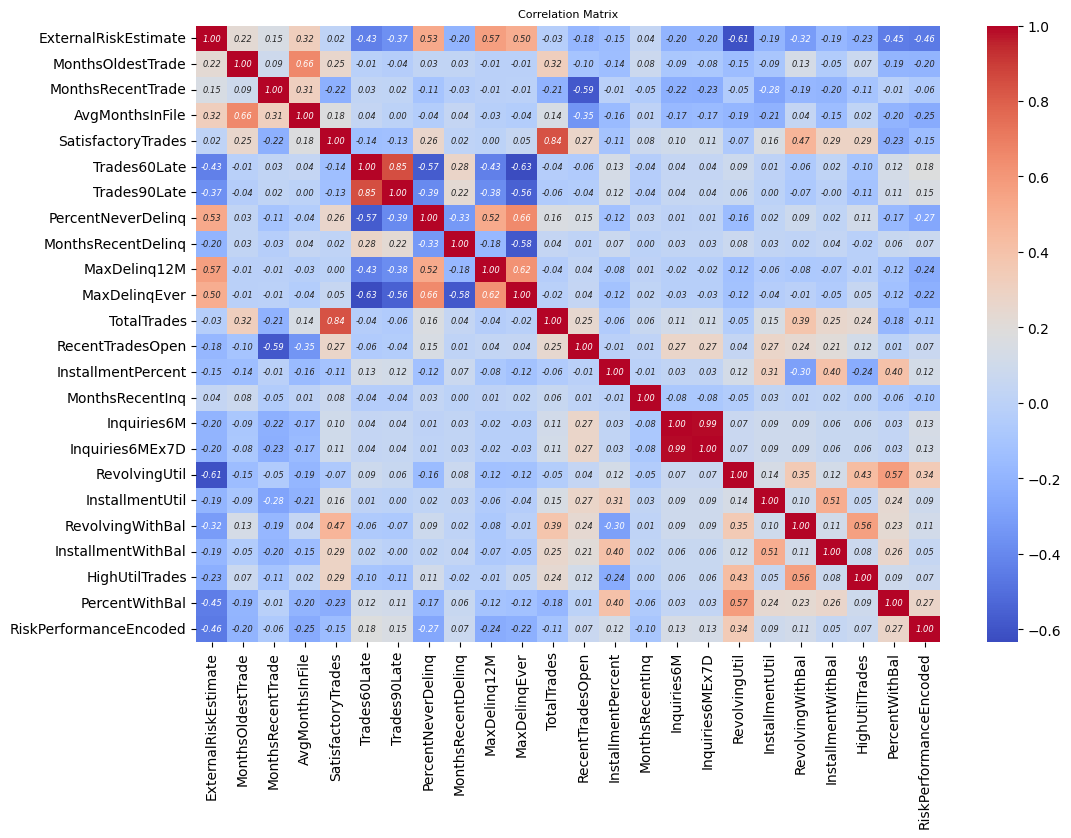

In [14]:
df = data.drop(columns=['RiskPerformance'])
correlation_matrix = df.corr(method='pearson')  # You can change to 'spearman' or 'kendall'
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            annot_kws={'size': 6, 'fontstyle': 'italic'})  # Adjust font size and style here

# Optionally, adjust the font size globally
plt.rcParams.update({'font.size': 6})  # This changes the font size everywhere

# Title (with adjusted font size)
plt.title('Correlation Matrix', fontsize=8)

plt.show()

### Feature Engineering

In [15]:
data['Inquiries7D'] = data['Inquiries6M'] - data['Inquiries6MEx7D']
data['RecentOpenTate'] = np.where(data['TotalTrades'] != 0, data['RecentTradesOpen']/ data['TotalTrades'], 0)
data['LateTradesProportion'] = np.where(data['TotalTrades'] != 0, (data['Trades60Late'] + data['Trades90Late']) / data['TotalTrades'], 0)
data['LongTermDelinquencyRate'] = np.where(data['MonthsOldestTrade'] != 0, data['MaxDelinqEver'] / data['MonthsOldestTrade'], 0)
data['RevolvingRate'] = np.where(data['TotalTrades'] != 0, data['RevolvingWithBal'] / data['TotalTrades'], 0)
data['InstallmentRate'] = np.where(data['TotalTrades'] != 0, data['InstallmentWithBal'] / data['TotalTrades'], 0)
data['HighUtilTradesRate'] = np.where(data['TotalTrades'] != 0, data['HighUtilTrades'] / data['TotalTrades'], 0)
data['LongTermDelinquencyRate'] = np.where(data['MonthsOldestTrade'] != 0, data['MaxDelinqEver'] / data['MonthsOldestTrade'], np.nan)
data['RecentCreditActivity'] = np.where(data['TotalTrades'] != 0, data['RecentTradesOpen'] / data['TotalTrades'], 0)
data['SatisfactoryTradesProportion'] = np.where(data['TotalTrades'] != 0, data['SatisfactoryTrades'] / data['TotalTrades'], 0)
data['LongerDelinq'] = np.where(data['MaxDelinq12M'] >= data['MaxDelinqEver'], 1, 0)

In [16]:
num_cols = data.drop(['RiskPerformance'], axis = 1).columns

In [17]:
X_ = data.drop(['RiskPerformance'], axis=1)
y = data['RiskPerformanceEncoded']  # Convert target to binary (1 for High Risk, 0 for Low Risk)

In [18]:
# Define a function to calculate quantiles and add them as new features
def add_binned_cat(dataframe, predictors):
    le = LabelEncoder()
    
    for predictor in predictors:
        try:
            # Apply qcut with the duplicates='drop' option to handle duplicate edges
            # First, determine the number of unique bins
            bins = pd.qcut(dataframe[predictor], q=4, duplicates='drop', retbins=True)[1]
            
            # Adjust the number of labels dynamically based on the number of unique bins
            labels = [f'Q{i}' for i in range(1, len(bins))]
            
            # Apply qcut with the correct number of labels
            dataframe[f'{predictor}_binned'] = pd.qcut(dataframe[predictor], q=len(labels), labels=labels, duplicates='drop')
            
            # Label encode the new binned column
            dataframe[f'{predictor}_binned'] = le.fit_transform(dataframe[f'{predictor}_binned'].astype(str))
        
        except ValueError as e:
            print(f"Could not create bins for {predictor} due to error: {e}")
    
    # Return the dataframe with new statistics columns
    return dataframe.drop([col for col in data.columns if 'qcut' in col], axis=1)

# List of predictors to process
predictors = ['HighUtilTrades',
'AvgMonthsInFile',
'MonthsOldestTrade',
'MaxDelinq12M',
'MaxDelinqEver',
'RevolvingUtil',
'PercentWithBal']

# Apply the function to the train dataset
X = add_binned_cat(X_, predictors)


In [19]:
X = X.drop(['RiskPerformanceEncoded'], axis=1)

In [20]:
X.shape

(8886, 40)

In [21]:
# Check if there are any non-numerical columns and print their names
non_numerical_columns = X.select_dtypes(exclude=[np.number]).columns

# Print the names of non-numerical columns
if len(non_numerical_columns) > 0:
    print("Non-numerical columns:")
    print(non_numerical_columns)
else:
    print("All columns are numerical.")

All columns are numerical.


### Train-test split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Development

In [23]:
# Build and tune LGBM model
lgbm_model = LGBMClassifier()

# Parameter grid for tuning LGBM
lgbm_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01,0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 0.9, 1],
}

with contextlib.redirect_stdout(None), contextlib.redirect_stderr(None):
    lgbm_grid = GridSearchCV(estimator=lgbm_model, param_grid=lgbm_param_grid, scoring='roc_auc', cv=3, verbose=2)
    lgbm_grid.fit(X_train, y_train)

# Best LGBM model
best_lgbm = lgbm_grid.best_estimator_

In [24]:
# LGBM predictions and metrics
y_pred_lgbm = best_lgbm.predict(X_test)
y_pred_proba_lgbm = best_lgbm.predict_proba(X_test)[:, 1]

lgbm_auc_roc = roc_auc_score(y_test, y_pred_proba_lgbm)
lgbm_accuracy = accuracy_score(y_test, y_pred_lgbm)
precision_lgbm, recall_lgbm, _ = precision_recall_curve(y_test, y_pred_proba_lgbm)
lgbm_pr_auc = auc(recall_lgbm, precision_lgbm)
# Print classification report and metrics for LGBM
print("LGBM Classification Report")
print(classification_report(y_test, y_pred_lgbm))

LGBM Classification Report
              precision    recall  f1-score   support

           0       0.75      0.72      0.73       878
           1       0.73      0.77      0.75       900

    accuracy                           0.74      1778
   macro avg       0.74      0.74      0.74      1778
weighted avg       0.74      0.74      0.74      1778



In [25]:
# Build and tune Random Forest model
rf_model = RandomForestClassifier()

# Parameter grid for tuning Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

with contextlib.redirect_stdout(None), contextlib.redirect_stderr(None):
    rf_grid = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, scoring='roc_auc', cv=3, verbose=2)
    rf_grid.fit(X_train, y_train)

In [26]:
# Best Random Forest model
best_rf = rf_grid.best_estimator_

# Random Forest predictions and metrics
y_pred_rf = best_rf.predict(X_test)
y_pred_proba_rf = best_rf.predict_proba(X_test)[:, 1]

rf_auc_roc = roc_auc_score(y_test, y_pred_proba_rf)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf)
rf_pr_auc = auc(recall_rf, precision_rf)

# Print classification report and metrics for Random Forest
print("Random Forest Classification Report")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       878
           1       0.73      0.76      0.75       900

    accuracy                           0.74      1778
   macro avg       0.74      0.74      0.74      1778
weighted avg       0.74      0.74      0.74      1778



In [27]:
# Build and tune XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Parameter grid for tuning XGBoost
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01,0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1],
}

with contextlib.redirect_stdout(None), contextlib.redirect_stderr(None):
    xgb_grid = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, scoring='roc_auc', cv=3, verbose=2)
    xgb_grid.fit(X_train, y_train)

# Best XGBoost model
best_xgb = xgb_grid.best_estimator_

In [28]:
# Metrics and visualization

# XGBoost predictions and metrics
y_pred_xgb = best_xgb.predict(X_test)
y_pred_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

xgb_auc_roc = roc_auc_score(y_test, y_pred_proba_xgb)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_proba_xgb)
xgb_pr_auc = auc(recall_xgb, precision_xgb)

# Print classification report and metrics for XGBoost
print("XGBoost Classification Report")
print(classification_report(y_test, y_pred_xgb))


XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       878
           1       0.73      0.77      0.75       900

    accuracy                           0.74      1778
   macro avg       0.74      0.74      0.74      1778
weighted avg       0.74      0.74      0.74      1778



## Details on model selection and the criteria you used to make your choices.
#### XGboost has the best performance
##### Below are some plots for XGboost metric

In selecting the model for this task, we evaluated multiple machine learning algorithms, including **XGBoost**, **LightGBM**, and **Random Forest**, based on their performance in handling tabular data with potentially high feature interactions and non-linear relationships. 

The selection criteria focused on AUC-ROC as it shows model's ability to differentiate between high-risk and low-risk applicants. We used GridSearchCV for hyperparameter tuning to ensure the models were optimized for our dataset, and ultimately selected XGBoost due to its superior performance in terms of AUC-ROC and its flexibility in capturing complex patterns in the data.

In [32]:
# Function to calculate confidence intervals using bootstrapping
def bootstrap_roc_auc(y_true, y_pred_proba, n_bootstraps=1000):
    # Ensure y_true and y_pred_proba are numpy arrays (handles the KeyError issue)
    y_true = np.array(y_true)  # Convert to NumPy array if it's a Pandas Series
    y_pred_proba = np.array(y_pred_proba)
    
    bootstrapped_tpr = []
    bootstrapped_fpr = np.linspace(0, 1, 100)  # Create consistent FPR values for interpolation
    rng = np.random.RandomState(42)  # Set random seed for reproducibility

    for i in range(n_bootstraps):
        # Bootstrap resample
        indices = rng.randint(0, len(y_pred_proba), len(y_pred_proba))  # Random sampling with replacement

        # Ensure there are at least two unique values (classes) in the resample
        if len(np.unique(y_true[indices])) < 2:
            continue  # Skip this iteration if not enough classes are present

        # Compute the ROC curve for the bootstrapped sample
        fpr, tpr, _ = roc_curve(y_true[indices], y_pred_proba[indices])
        bootstrapped_tpr.append(np.interp(bootstrapped_fpr, fpr, tpr))  # Interpolate the TPR values

    bootstrapped_tpr = np.array(bootstrapped_tpr)
    mean_tpr = np.mean(bootstrapped_tpr, axis=0)  # Mean of bootstrapped TPRs
    std_tpr = np.std(bootstrapped_tpr, axis=0)  # Standard deviation of bootstrapped TPRs

    # Confidence interval (95%)
    tpr_upper = np.minimum(mean_tpr + 1.96 * std_tpr, 1)
    tpr_lower = np.maximum(mean_tpr - 1.96 * std_tpr, 0)

    return bootstrapped_fpr, mean_tpr, tpr_lower, tpr_upper

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
xgb_auc_roc = roc_auc_score(y_test, y_pred_proba_xgb)
fpr_boot, mean_tpr, tpr_lower, tpr_upper = bootstrap_roc_auc(y_test, y_pred_proba_xgb)

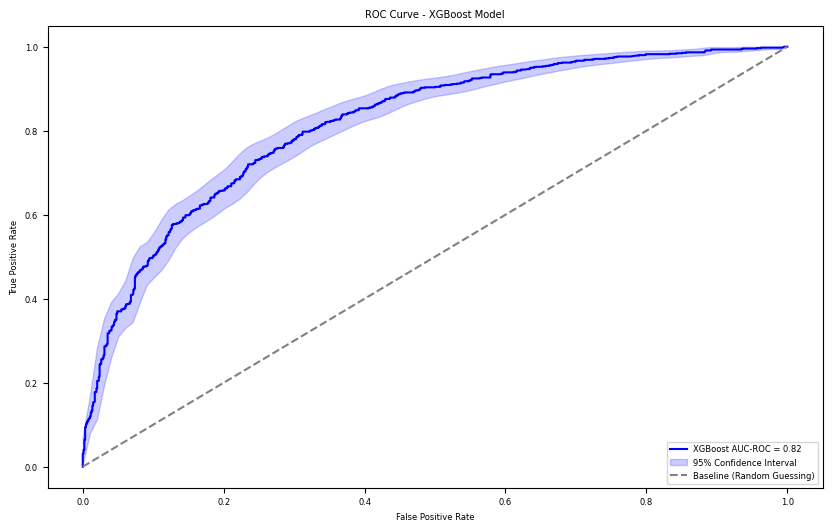

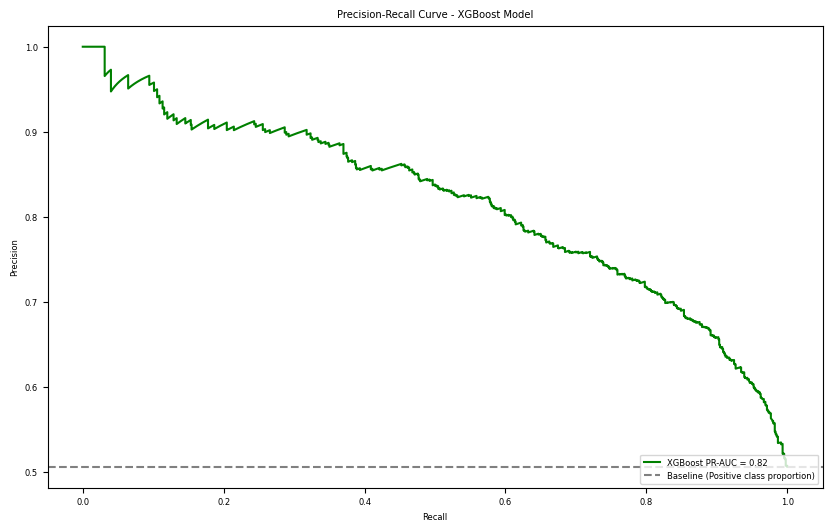

In [33]:
# Plot ROC Curve with confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost AUC-ROC = {xgb_auc_roc:.2f}', color='blue')
plt.fill_between(fpr_boot, tpr_lower, tpr_upper, color='blue', alpha=0.2, label="95% Confidence Interval")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Baseline (Random Guessing)")  # Baseline
plt.title('ROC Curve - XGBoost Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall Curve with baseline
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_proba_xgb)
xgb_pr_auc = auc(recall_xgb, precision_xgb)

# Calculate baseline for Precision-Recall curve (positive class proportion in y_test)
baseline_pr = y_test.mean()

plt.figure(figsize=(10, 6))
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost PR-AUC = {xgb_pr_auc:.2f}', color='green')
plt.axhline(y=baseline_pr, color='gray', linestyle='--', label="Baseline (Positive class proportion)")
plt.title('Precision-Recall Curve - XGBoost Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.show()

### Model Ensemble

##### We have done a simple model ensemble here, but it did not help improving model performance.

In [34]:
# Get predicted probabilities from each model
y_pred_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]
y_pred_proba_lgbm = best_lgbm.predict_proba(X_test)[:, 1]
y_pred_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Assign weights based on model performance (example weights; adjust based on actual model performance)
weight_xgb = 0.45   # XGBoost
weight_lgbm = 0.35  # LightGBM
weight_rf = 0.2    # Random Forest

# Calculate the weighted average of predicted probabilities
y_pred_proba_ensemble = (weight_xgb * y_pred_proba_xgb + weight_lgbm * y_pred_proba_lgbm + weight_rf * y_pred_proba_rf)

# Convert probabilities to binary predictions (0 or 1) using a threshold of 0.5
y_pred_ensemble = (y_pred_proba_ensemble >= 0.5).astype(int)

# Evaluate the weighted ensemble model
ensemble_auc_roc = roc_auc_score(y_test, y_pred_proba_ensemble)
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
precision_ensemble, recall_ensemble, _ = precision_recall_curve(y_test, y_pred_proba_ensemble)
ensemble_pr_auc = auc(recall_ensemble, precision_ensemble)
print(ensemble_auc_roc)

0.8184092634776007


### Insights from model

### How the model determines whether a loan application is likely to be "Low Risk" or "High Risk"?

The model primarily uses a combination of credit score (**ExternalRiskEstimate**), credit utilization(**RevolvingUtil**), delinquent history (**PercentNeverDelinq**), and account age (**AvgMonthsInFile**) to predict whether a loan application is high risk or low risk. 

Based on the SHAP values, these key features collectively drive the model’s decisions on whether a loan applicant is classified as high risk or low risk.

**Low-risk decisions**: Typically driven by applicants with:

- Higher ExternalRiskEstimate (better credit score),
- Lower RevolvingUtil (responsible credit use),
- High PercentNeverDelinq (solid payment history),
- Older AvgMonthsInFile (longer account history)
- Fewer recent credit inquiries.

**High-risk decisions**: Typically driven by applicants with:

- Lower ExternalRiskEstimate (poor credit score),
- Higher RevolvingUtil (heavy credit usage),
- More delinquent months (lower PercentNeverDelinq),
- Younger AvgMonthsInFile (newer accounts)
- More recent credit inquiries.

In addition to individual feature effects, the model also accounts for interactions between key features:

- **ExternalRiskEstimate** and **MonthsRecentInq**:
    Even with a good credit score (high ExternalRiskEstimate), the model flags applicants with recent credit inquiries as slightly higher risk.
- **RevolvingUtil** and **PercentNeverDelinq**:
    High credit utilization (RevolvingUtil) can dampen the effect of a strong non-delinquency record (PercentNeverDelinq). Even if an applicant hasn’t been delinquent, high utilization indicates financial stress and results in higher risk.



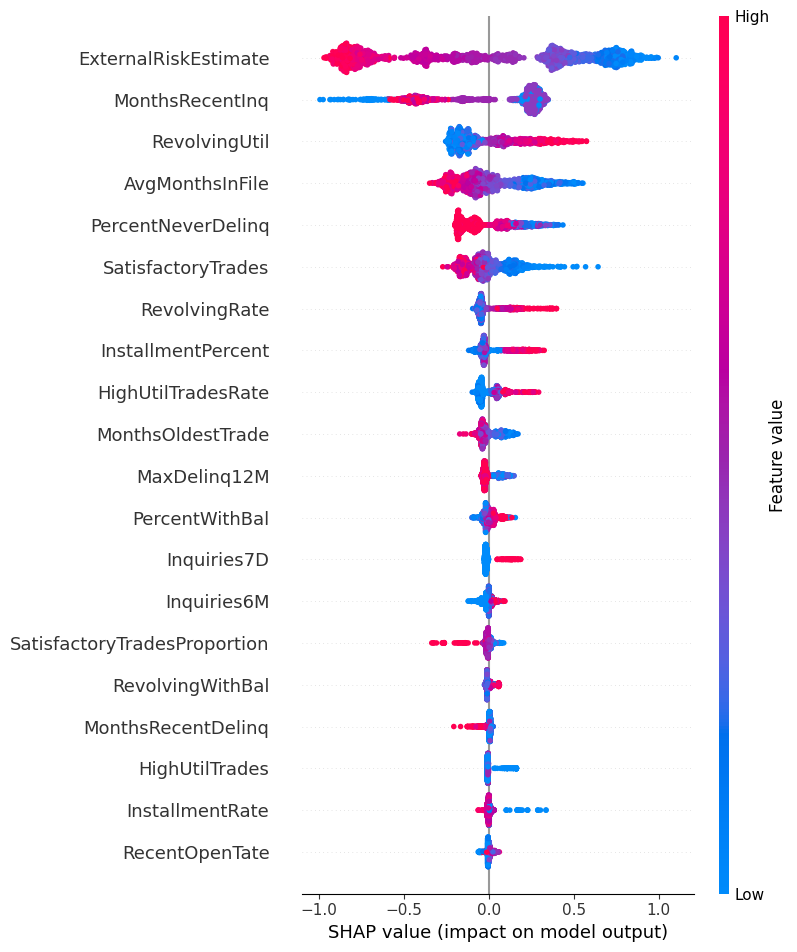

In [35]:
# Create explainer
explainer = shap.Explainer(best_xgb, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Global feature importance (summary plot)
shap.summary_plot(shap_values, X_test)

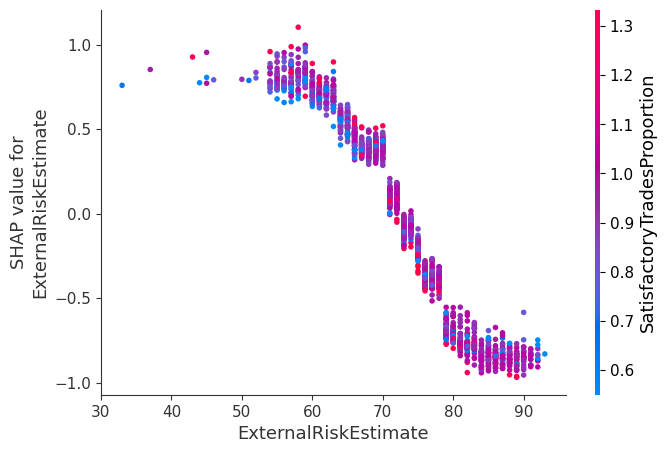

In [36]:
# Visualize the SHAP values for ExternalRiskEstimate
shap.dependence_plot("ExternalRiskEstimate", shap_values.values, X_test)

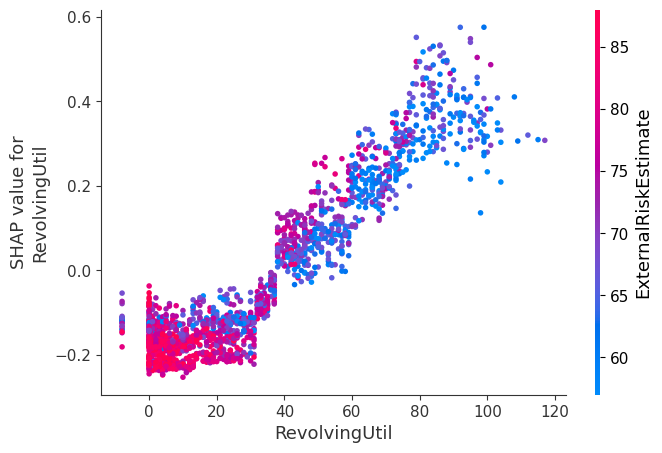

In [37]:
# Visualize the SHAP values for RevolvingUtil
shap.dependence_plot("RevolvingUtil", shap_values.values, X_test)

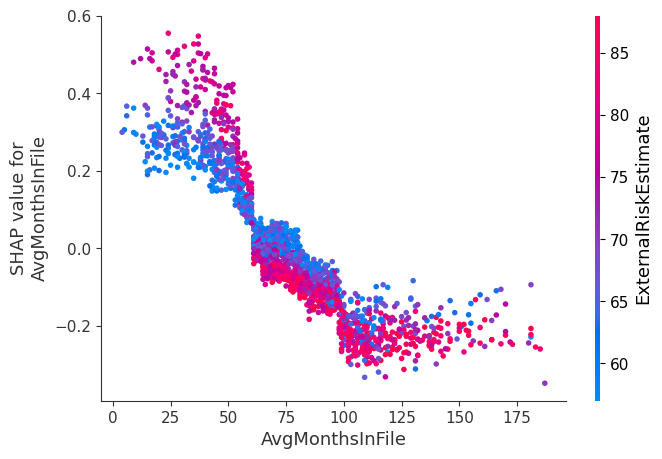

In [38]:
# Visualize the SHAP values for AvgMonthsInFile
shap.dependence_plot("AvgMonthsInFile", shap_values.values, X_test)

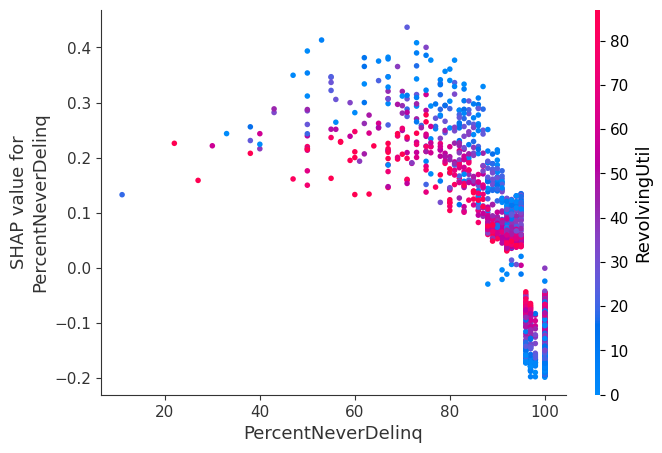

In [39]:
# Visualize the SHAP values for AvgMonthsInFile
shap.dependence_plot("PercentNeverDelinq", shap_values.values, X_test)

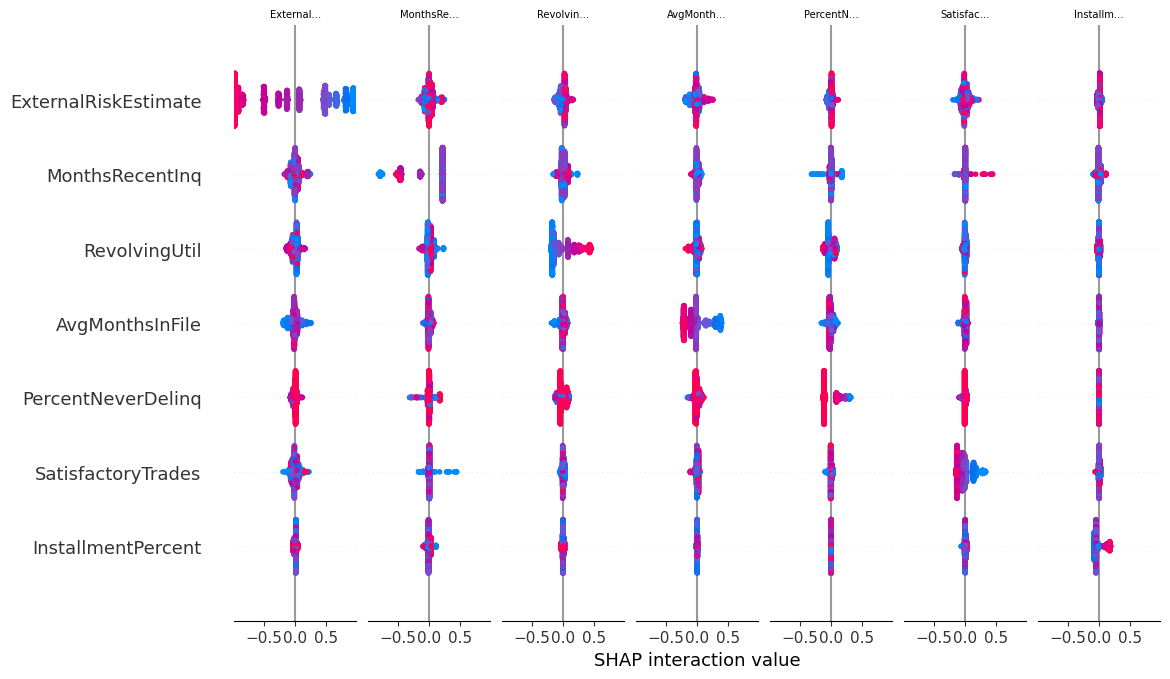

In [40]:
# SHAP interaction values
interaction_values = shap.TreeExplainer(best_xgb).shap_interaction_values(X_test)
shap.summary_plot(interaction_values, X_test)
# shap.dependence_plot("PercentNeverDelinq", shap_values.values, X_test)

### Analysis of the key features that drive these predictions and their impact on the decision.

##### Top 5 important features
1. **ExternalRiskEstimate**: This feature likely represents a credit risk score.
    
    Higher values indicate better creditworthiness, leading to  lower risk classifications.
    
    Correlation: The correlation matrix shows this feature has a significant negative correlation with RevolvingUtil (-0.66) and positive correlations with AvgMonthsInFile (0.30) and PercentNeverDelinq (0.52). It shows that this features is negatively correlated with Credit Utilization, positively with account history and payment history, showing it's a central indicator of overall creditworthiness.
    
2. **MonthsRecentInq**: how recently the applicant made a credit inquiry (excluding last 7 days).
    
    This suggests that applicants who have recently made more inquiries tend to be classified as higher risk, while those with fewer recent inquiries are seen as lower risk.
    
    Correlation: Minimal with other features, suggesting independent contribution to risk prediction.
    
3. **RevolvingUtil**: the percentage of the credit limit that the applicant is using.

    Applicants who are using a high percentage of their credit limit are seen as more likely to be high risk, while those with low credit utilization are seen as low risk.

4. **AvgMonthsInFile**: average months on record.
    
    Applicants with older accounts tend to be seen as more stable and lower risk, while those with newer accounts may be considered riskier.
    
5. **PercentNeverDelinq**: percentage of trades never delinquent.
    
    Applicants who have a high percentage of trades that never delinquent are considered lower risk, while those with a history of delinquencies are considered higher risk.

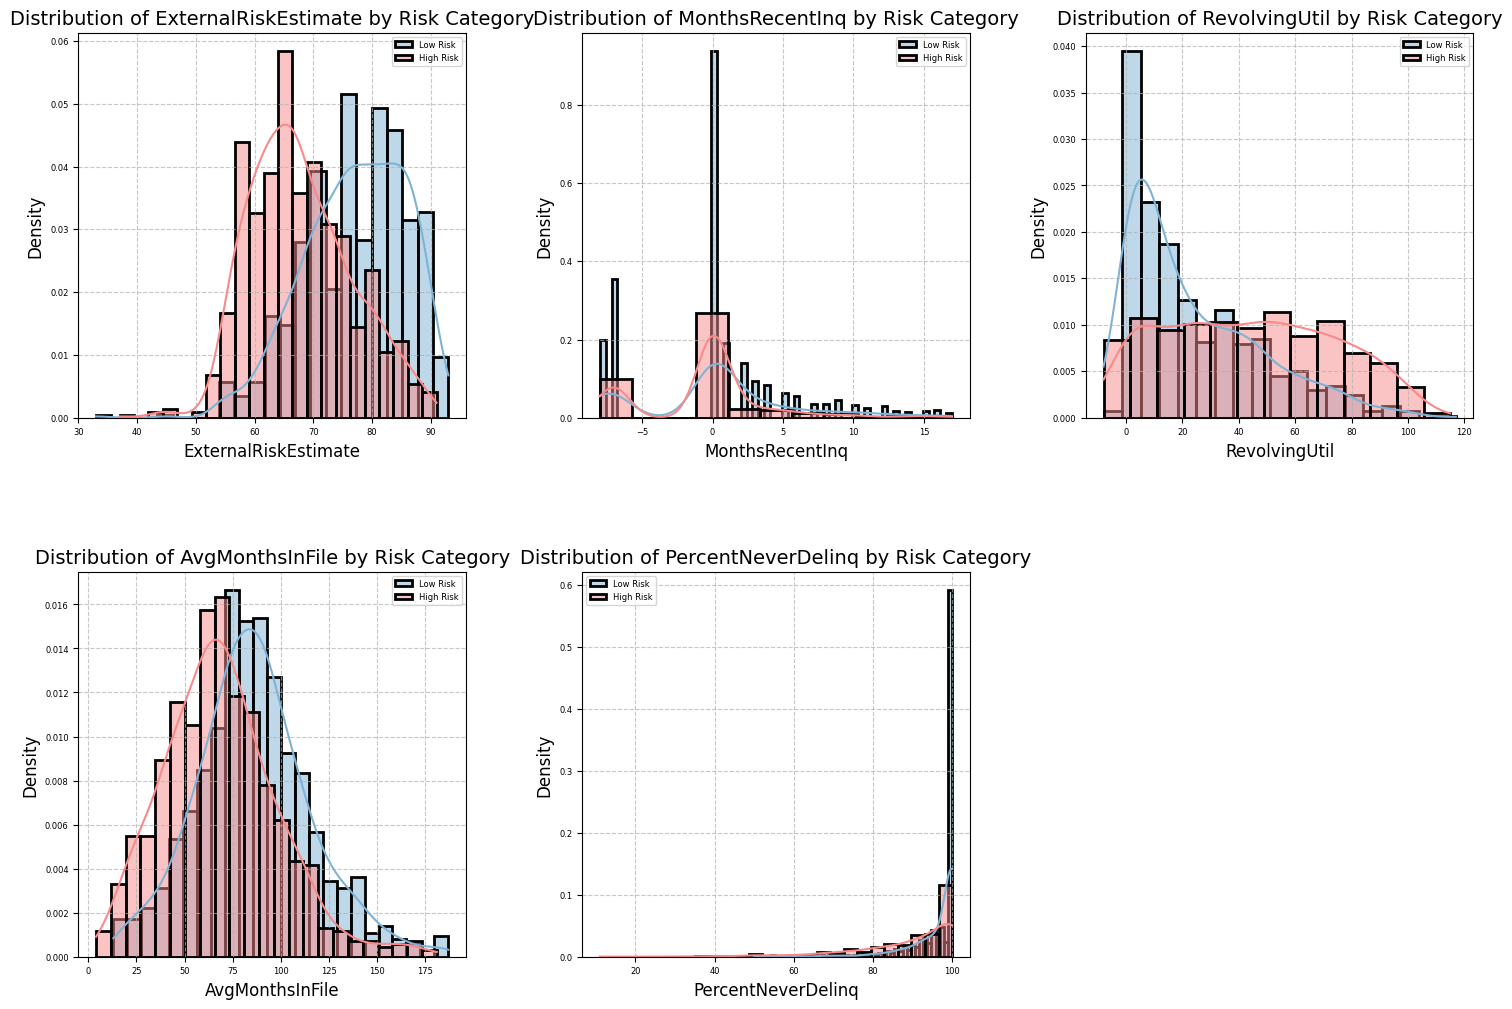

In [41]:
# Assuming 'y_test' is the target variable where 0 = low risk, 1 = high risk
data['ExternalRiskEstimate'] = X_test['ExternalRiskEstimate']
data['RiskCategory'] = y_test

# Define colors
light_blue = '#7fb3d5'  # Light Blue
light_coral = '#f88a8a'  # Light Coral

# Create a 2x3 grid for subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Adjust layout
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Plot 1: ExternalRiskEstimate
sns.histplot(data[data['RiskCategory'] == 0]['ExternalRiskEstimate'], color=light_blue, label='Low Risk', kde=True, stat='density', linewidth=2, ax=axs[0, 0])
sns.histplot(data[data['RiskCategory'] == 1]['ExternalRiskEstimate'], color=light_coral, label='High Risk', kde=True, stat='density', linewidth=2, ax=axs[0, 0])
axs[0, 0].set_title('Distribution of ExternalRiskEstimate by Risk Category', fontsize=14)
axs[0, 0].set_xlabel('ExternalRiskEstimate', fontsize=12)
axs[0, 0].set_ylabel('Density', fontsize=12)
axs[0, 0].legend()
axs[0, 0].grid(True, linestyle='--', alpha=0.7)

# Plot 2: MonthsRecentInq
sns.histplot(data[data['RiskCategory'] == 0]['MonthsRecentInq'], color=light_blue, label='Low Risk', kde=True, stat='density', linewidth=2, ax=axs[0, 1])
sns.histplot(data[data['RiskCategory'] == 1]['MonthsRecentInq'], color=light_coral, label='High Risk', kde=True, stat='density', linewidth=2, ax=axs[0, 1])
axs[0, 1].set_title('Distribution of MonthsRecentInq by Risk Category', fontsize=14)
axs[0, 1].set_xlabel('MonthsRecentInq', fontsize=12)
axs[0, 1].set_ylabel('Density', fontsize=12)
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.7)

# Plot 3: RevolvingUtil
sns.histplot(data[data['RiskCategory'] == 0]['RevolvingUtil'], color=light_blue, label='Low Risk', kde=True, stat='density', linewidth=2, ax=axs[0, 2])
sns.histplot(data[data['RiskCategory'] == 1]['RevolvingUtil'], color=light_coral, label='High Risk', kde=True, stat='density', linewidth=2, ax=axs[0, 2])
axs[0, 2].set_title('Distribution of RevolvingUtil by Risk Category', fontsize=14)
axs[0, 2].set_xlabel('RevolvingUtil', fontsize=12)
axs[0, 2].set_ylabel('Density', fontsize=12)
axs[0, 2].legend()
axs[0, 2].grid(True, linestyle='--', alpha=0.7)

# Plot 4: AvgMonthsInFile
sns.histplot(data[data['RiskCategory'] == 0]['AvgMonthsInFile'], color=light_blue, label='Low Risk', kde=True, stat='density', linewidth=2, ax=axs[1, 0])
sns.histplot(data[data['RiskCategory'] == 1]['AvgMonthsInFile'], color=light_coral, label='High Risk', kde=True, stat='density', linewidth=2, ax=axs[1, 0])
axs[1, 0].set_title('Distribution of AvgMonthsInFile by Risk Category', fontsize=14)
axs[1, 0].set_xlabel('AvgMonthsInFile', fontsize=12)
axs[1, 0].set_ylabel('Density', fontsize=12)
axs[1, 0].legend()
axs[1, 0].grid(True, linestyle='--', alpha=0.7)

# Plot 5: PercentNeverDelinq
sns.histplot(data[data['RiskCategory'] == 0]['PercentNeverDelinq'], color=light_blue, label='Low Risk', kde=True, stat='density', linewidth=2, ax=axs[1, 1])
sns.histplot(data[data['RiskCategory'] == 1]['PercentNeverDelinq'], color=light_coral, label='High Risk', kde=True, stat='density', linewidth=2, ax=axs[1, 1])
axs[1, 1].set_title('Distribution of PercentNeverDelinq by Risk Category', fontsize=14)
axs[1, 1].set_xlabel('PercentNeverDelinq', fontsize=12)
axs[1, 1].set_ylabel('Density', fontsize=12)
axs[1, 1].legend()
axs[1, 1].grid(True, linestyle='--', alpha=0.7)

# Plot 6: Empty (for spacing)
axs[1, 2].axis('off')

plt.show()

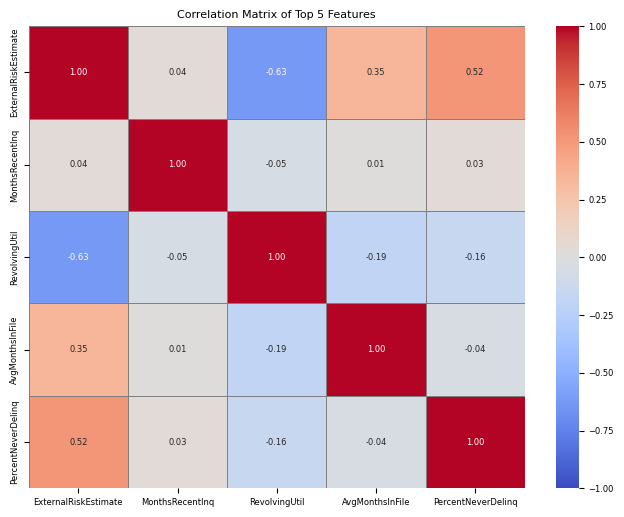

In [42]:
# Define the top 5 features to analyze
top_features = ['ExternalRiskEstimate', 'MonthsRecentInq', 'RevolvingUtil', 'AvgMonthsInFile', 'PercentNeverDelinq']

# Select the relevant columns from the dataset
data_top_features = data[top_features]

# Compute the correlation matrix
correlation_matrix = data_top_features.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, linewidths=0.5, linecolor='gray')
plt.title('Correlation Matrix of Top 5 Features', fontsize=8)
plt.show()

### Banker explaining reasoing behind model output

For individual customer, bankers can explain the result using shap.force_plot. Taking the following plot as an example, banker can tel  customer that:

    "After reviewing your credit profile, it's currently classified as moderate to high risk. This is mainly due to your high credit usage (93%), which may signal reliance on credit, and a few missed or delayed payments in the past. Additionally, recent credit inquiries and multiple accounts with balances add to the risk.

    On the bright side, you’ve managed 16 accounts well, and your credit history shows no missed payments for a significant time, which is a strong point.

    To improve, focus on reducing your credit usage and avoiding new credit applications. We’re here to help you explore options to improve your score."

In [43]:
# Local explanations for a single prediction
shap.initjs()  
shap.force_plot(shap_values[1].base_values, shap_values[1].values, X_train.iloc[1, :])

## AI solution
The result can be generated automated using LangChain & OpenAI
    
Howeverm the code below is <span style="color: red;">not working</span> due to the missing open-AI key. I put the result here as an example:

In [ ]:
# pip install langchain

In [ ]:
# pip install langchain-community

In [ ]:
# pip install openai

In [ ]:
# from langchain.prompts import PromptTemplate

In [ ]:
# shap_values = explainer.shap_values(X_test)

# # Assume you have a pre-trained model and you are looking at the first instance
# feature_contributions = shap_values[0]  # First instance
# feature_names = X_test.columns

# # Function to process SHAP values and get top 3-5 features
# def get_top_features(shap_values, feature_names, top_n=5):
#     # Create a list of tuples (feature_name, shap_value) and sort by absolute shap value
#     feature_importance = sorted(
#         zip(feature_names, shap_values), key=lambda x: abs(x[1]), reverse=True
#     )
    
#     # Return the top N features
#     return feature_importance[:top_n]

# # Generate a friendly explanation using LangChain
# def generate_friendly_explanation(top_features):
#     # Create a list of features that increase risk and those that decrease it
#     increasing_risk = [f"{name} (+{value:.2f})" for name, value in top_features if value > 0]
#     decreasing_risk = [f"{name} ({value:.2f})" for name, value in top_features if value < 0]

#     # Prepare input variables for LangChain
#     input_variables = {
#         "increasing_features": ', '.join(increasing_risk),
#         "decreasing_features": ', '.join(decreasing_risk)
#     }

#     # Template for LangChain to generate friendly explanation
#     template = """
#     Based on your current credit profile, there are a few key factors influencing your overall credit risk score:
    
#     The factors increasing your risk are: {increasing_features}.
#     The factors helping to lower your risk are: {decreasing_features}.
    
#     We recommend focusing on the areas that are increasing your risk to improve your score. Addressing these points can make a significant difference.
#     """

#     # Initialize the LangChain PromptTemplate
#     prompt = PromptTemplate(
#         input_variables=["increasing_features", "decreasing_features"],
#         template=template,
#     )

# #     return prompt
#     # Set up the OpenAI API key (replace with your API key or other LLM provider)
#     openai_api_key = 'your-openai-api-key'
#     llm = OpenAI(openai_api_key=openai_api_key)

#     # Create the LangChain chain and run it to generate the friendly explanation
#     llm_chain = LLMChain(llm=llm, prompt=prompt)
#     friendly_response = llm_chain.run(input_variables)

#     return friendly_response

# # Get the top 5 features affecting the prediction
# top_features = get_top_features(feature_contributions, feature_names, top_n=5)

# # Generate the explanation
# explanation = generate_friendly_explanation(top_features)

# # Print the friendly explanation
# # print(explanation)


Example output:

    "Your credit risk is currently assessed as moderate. Several factors contribute to this. The fact that your revolving credit utilization is high and you've had a few recent delinquencies raises concerns. However, it’s great to see that you have a solid history of managing accounts, with many satisfactory trade lines and no missed payments for the majority of your accounts. To improve your profile, we recommend reducing your credit utilization by paying down some of your revolving balances and avoiding any new delinquencies. This should help bring your score down over time."